## In this notebook, I'll generate figure panels which involve loading the mutant trajectories data. 

Want to keep things separate from the main notebook where I make the rest of the figures.

In [17]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm
import os, re
from pathlib import Path
from Bio.SeqIO.FastaIO import SimpleFastaParser

In [6]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper/Analysis/Part_3_TnSeq_analysis/Generate_figures


In [7]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the breseq output data
path = Path(cwd)
repo = str(path.parents[2])
print(path.parents[2]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper


In [9]:
#input directory with all the counts data
data_directory = repo+'/Data/Mutant_Trajectories/'
#names of libraries
libraries = ['REL606', 'REL607', 'REL11330', 'REL11333', 'REL11364', 'REL11336', 'REL11339', 'REL11389', 'REL11392', 'REL11342', 'REL11345', 'REL11348', 'REL11367', 'REL11370']
#more interpretable names for the figures in the paper
libraries2 = ['REL606', 'REL607', 'Ara-1', 'Ara-2', 'Ara-3', 'Ara-4', 'Ara-5', 'Ara-6', 'Ara+1', 'Ara+2', 'Ara+3', 'Ara+4', 'Ara+5', 'Ara+6']

In [104]:
metadata_path = repo+'/Metadata/'
datapath = repo + '/Analysis/Part_3_TnSeq_analysis/Processed_data_for_plotting/'
figpath = repo +'/Analysis/Plots_for_paper/'

In [18]:
#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

In [12]:
#all the information from the fitness assay condensed into a couple of matrices
n_ta_sites = 211995
counts_all_green = np.zeros([len(libraries), 5, n_ta_sites])
counts_all_red = np.zeros([len(libraries), 5, n_ta_sites])

for k in range(len(libraries)):
    #loading the new file where I have the counts for each TA site for all time points
    gname = data_directory+'green_'+libraries[k]+'_merged_all_TAsites.txt'
    greendata = np.loadtxt(gname)
    rname = data_directory+'red_'+libraries[k]+'_merged_all_TAsites.txt'
    reddata = np.loadtxt(rname)
    #now for extracting the UMI corrected coutns
    counts_all_green[k,:,:] = greendata[2:11:2,:]
    counts_all_red[k,:,:] = reddata[2:11:2,:]

## Fig. S2: Distribution of insertions across the genome

### Panel A) A map of insertions across the genome in the LTEE ancestor REL606

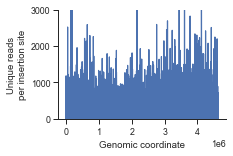

In [85]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(3,2))
    plt.plot(ta_sites, counts_all_green[0,0,:])  #zeroth timepoint for the ancestor
#     plt.yscale('symlog', linthresh=3000)
#     plt.yscale('log')
    plt.ylim(0,3000)
    plt.yticks([0,1000,2000,3000])
    plt.xlabel('Genomic coordinate')
    plt.ylabel('Unique reads\nper insertion site')
    sns.despine()
    plt.savefig(figpath+"insertion_map.pdf", format='pdf',bbox_inches='tight')

### Panel B) Number of TA sites represented at t0

In [86]:
pops_include = [0,2,3,4,5,6,7,1,8,9,10,11,12,13]

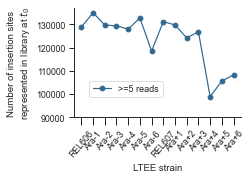

In [95]:
viridis = sns.color_palette('viridis', n_colors=2)
line = 0
with sns.axes_style('ticks'):
    fig,ax = plt.subplots(1,1,figsize=(3,2))
    for thresh in [5]:
        ax.plot(np.array(libraries2)[pops_include], np.sum(counts_all_green[pops_include,0,:]>=thresh, axis=1),'o-', color=viridis[line], label=f'>={thresh} reads')
        line+=1
    fig.legend(loc='center', prop={'size': 9})
    ax.set_xlabel('LTEE strain')
    ax.set_ylabel('Number of insertion sites\nrepresented in library at $t_{0}$')
    ax.set_ylim(90000)
    ax.tick_params(axis = 'x', size=8, rotation=50) 
    sns.despine()
    plt.savefig(figpath+"insertion_numbers.pdf", format='pdf',bbox_inches='tight')

### Mean fitness trajectory over the assay for all the populations.

For every timepoint, I will calculate the mean fitness as follows:

$$ \mu_{pop} = \sum_{gene}(s_{gene}p_{gene})$$

where p_gene is the fraction of counts summed over the interior of the gene, and s_gene is the fitness obtained from the log-linear regression approach.

Restricting this sum over genes where a fitness was calculated.

In [96]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")

In [97]:
domain_essential = ['mqsA', 'waaU', 'yabQ', 'yafF', 
                    'yibJ', 'yqgD', 'ftsK', 'ftsN', 
                    'ftsX', 'lptC', 'ribB', 'rne',
                    'secM', 'spoT', 'yejM', 'polA']

In [98]:
#removing the domain essential genes from our analysis
metadata = all_data[~all_data['Gene Name'].isin(domain_essential)]

In [99]:
names = metadata['Gene Name']
gene_start = metadata['Start of Gene']
gene_end = metadata['End of Gene']
strand = metadata['Strand']
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = metadata['Locus Tag (K12 reference)']
uniprot_rel606 = metadata['UniProt ID']
product = metadata['Protein Product']

In [100]:
#list of genes to be excluded from analysis as they lie within large deletions
exclude_genes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/output/Deleted_genes_REL606_k12annotated.txt")

In [105]:
#loading the fitness data files now:
fitness_gene_corrected = np.load(datapath+'/fitness_corrected_genes.npy')
fitness_gene_corrected = fitness_gene_corrected[metadata.index]

In [108]:
gene = 'kch'
pop = 0
# print('Number of interior TA sites:', list(names).index(gene))

Number of interior TA sites: 1128


In [113]:
counts_all_red[pop,:,search_gene(locations,ta_sites,list(names).index(gene))].sum(axis=0)

array([1047.,  438.,  848., 1342., 1070.])

### Counting the number of reads within genes where a fitness was calculated

In [110]:
def search_gene(locations,ta_sites,i):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        search_area = (ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p)
    #if the gene is on the reverse strand
    elif locations[i,2]==-1:
        search_area = (ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p)
    return search_area

In [106]:
counts_interior_g = np.zeros([len(names),len(libraries),5])
counts_interior_r = np.zeros([len(names),len(libraries),5])

In [174]:
for gene in range(len(names)):
    for pop in range(len(libraries)):
        counts_interior_g[gene, pop, :] = np.sum(counts_all_green[pop,:,search_gene(locations,ta_sites,gene)],axis=0)
        counts_interior_r[gene, pop, :] = np.sum(counts_all_red[pop,:,search_gene(locations,ta_sites,gene)],axis=0)

In [175]:
counts_interior_g = np.minimum(counts_interior_g, 1e5)
counts_interior_r = np.minimum(counts_interior_r, 1e5)


In [176]:
mean_fitness_g = np.zeros([len(libraries), 5])
mean_fitness_r = np.zeros([len(libraries), 5])

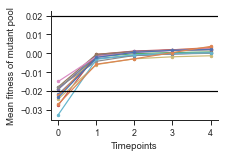

In [180]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(3,2))
    for pop in range(len(libraries)):
        if pop not in [3,11]:
            genes_compare = np.where(fitness_gene_corrected[:,pop,0]>-1)[0]
            interior_g = counts_interior_g[genes_compare, pop, :]
            interior_r = counts_interior_r[genes_compare, pop, :]    
            interior_g = interior_g/np.sum(interior_g, axis=0)
            interior_r = interior_r/np.sum(interior_r, axis=0)
            fitness_g = fitness_gene_corrected[genes_compare, pop, 0]
            fitness_r = fitness_gene_corrected[genes_compare, pop, 1]

            mean_fitness_g[pop] = np.sum(fitness_g*interior_g.T, axis=1)
            mean_fitness_r[pop] = np.sum(fitness_r*interior_r.T, axis=1)
            
            plt.plot((mean_fitness_r[pop]+mean_fitness_g[pop])/2,'.-')

    plt.axhline(-0.02, color='black')
    plt.axhline(0.02, color='black')

plt.xlabel('Timepoints')
plt.xticks([0,1,2,3,4])
plt.ylabel('Mean fitness of mutant pool')
sns.despine()

In [181]:
fitness_gene_corrected[list(names).index('envZ')]

array([[-0.13063081, -0.15099761],
       [-0.0685008 , -0.08537728],
       [-0.25902006, -0.24453295],
       [-0.08744697, -0.12464443],
       [-0.15228419, -0.12404101],
       [-0.2886439 , -0.29675754],
       [-0.37027462, -0.42137416],
       [-0.30712731, -0.34029927],
       [-0.45823219, -0.42632302],
       [-0.35886037, -0.32079361],
       [-0.24322781, -0.27319032],
       [-0.30189023, -0.32250363],
       [-0.36189095, -0.32558425],
       [-0.41333772, -0.43233759]])